<a href="https://colab.research.google.com/github/MoMahmoud8/Digit-Recognizer/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patool


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 8.9 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive("/content/test.csv.zip")
patoolib.extract_archive("/content/train.csv.zip")


patool: Extracting /content/test.csv.zip ...
patool: running /usr/bin/7z x -o./Unpack_4j8ei65t -- /content/test.csv.zip
patool: ... /content/test.csv.zip extracted to `test.csv'.
patool: Extracting /content/train.csv.zip ...
patool: running /usr/bin/7z x -o./Unpack_jst2ripo -- /content/train.csv.zip
patool: ... /content/train.csv.zip extracted to `train.csv'.


'train.csv'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('/content/train.csv')
#test = pd.read_csv('/content/test.csv')

In [ ]:
train.shape

(42000, 785)

In [ ]:
#test.shape

(28000, 784)

In [ ]:
#split data from the target
X = train.drop(['label'], 1).values
y = train['label'].values

<ipython-input-10-a59f6058bd32>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = train.drop(['label'], 1).values


In [ ]:
X.shape

(42000, 784)

In [ ]:
#normalization
X = X / 255.0


In [ ]:
#reshape data
X = X.reshape(-1,28,28,1)


In [ ]:
y

array([1, 0, 1, ..., 7, 6, 9])

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils import to_categorical
y = to_categorical(y)
print(f"Label size {y.shape}")

Label size (42000, 10)


In [ ]:
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)


Visualization

In [ ]:
import matplotlib.pyplot as plt

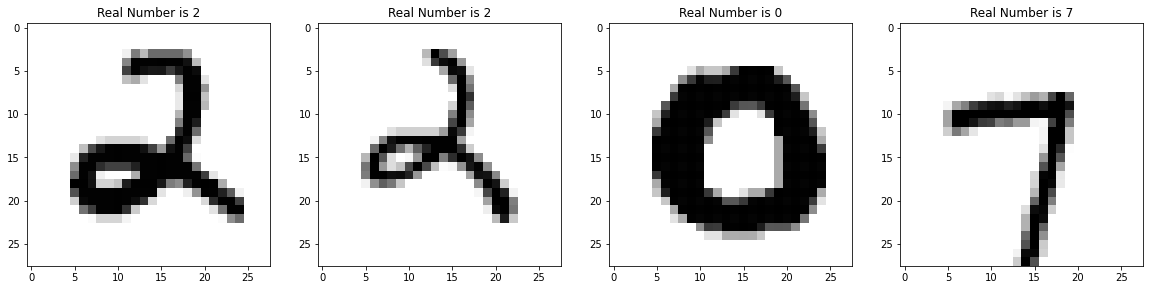

In [ ]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

CNN Model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import BatchNormalization


In [ ]:
model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 128)        

Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

Early Stopping , ReduceLROnPlateau

In [ ]:
epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size
#early stop
es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )
#ReduceLROnPlateau
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
# Fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/100


<ipython-input-51-2676189ccf2f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


295/295 [==============================] - 43s 144ms/step - loss: 0.1608 - accuracy: 0.9511 - val_loss: 2.3598 - val_accuracy: 0.3005 - lr: 0.0010
Epoch 2/100
295/295 [==============================] - 12s 41ms/step - loss: 0.0651 - accuracy: 0.9803 - val_loss: 0.0875 - val_accuracy: 0.9717 - lr: 0.0010
Epoch 3/100
295/295 [==============================] - 12s 41ms/step - loss: 0.0501 - accuracy: 0.9854 - val_loss: 0.0642 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/100
295/295 [==============================] - 12s 41ms/step - loss: 0.0430 - accuracy: 0.9868 - val_loss: 0.0679 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/100
295/295 [==============================] - 12s 42ms/step - loss: 0.0433 - accuracy: 0.9868 - val_loss: 0.0777 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 6/100
295/295 [==============================] - 13s 46ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0384 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 7/100
295/295 [==============================] - 12s 42ms

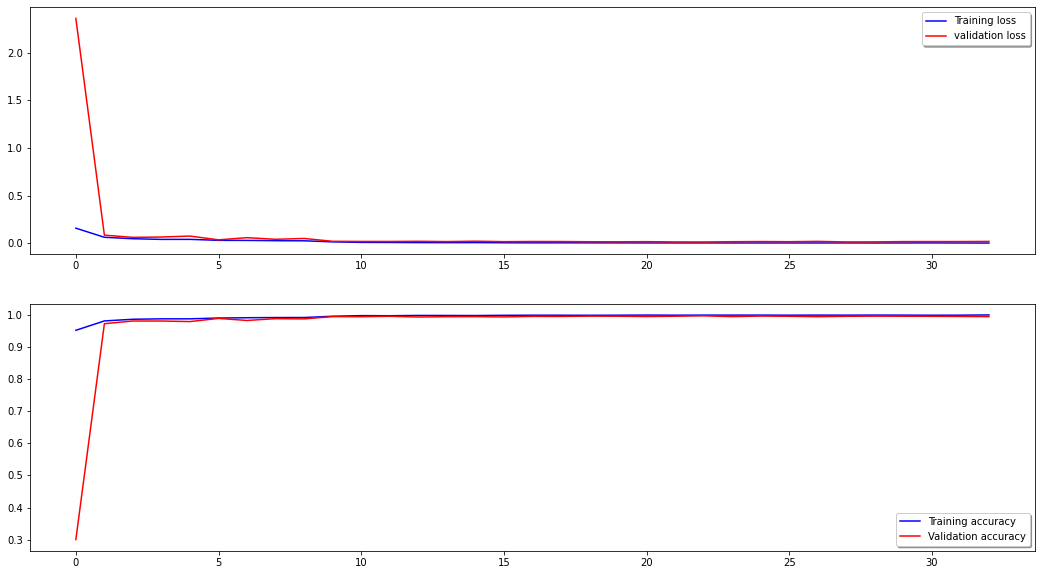

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

132/132 [==============================] - 0s 2ms/step


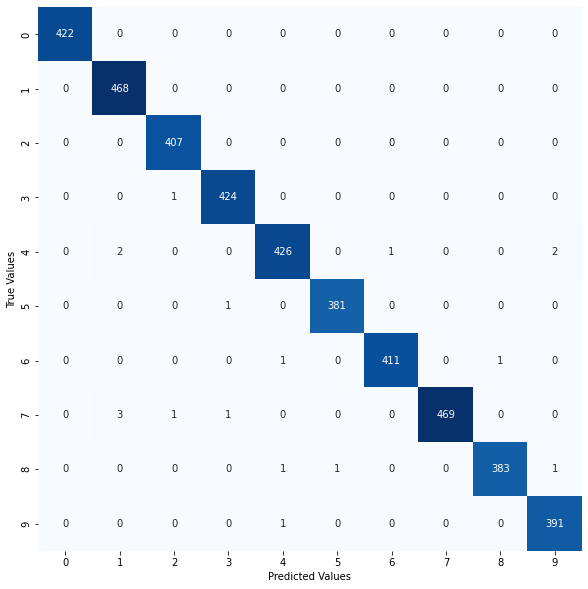

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig = plt.figure(figsize=(10, 10)) # Set Figure
y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]
Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

132/132 [==============================] - 0s 2ms/step


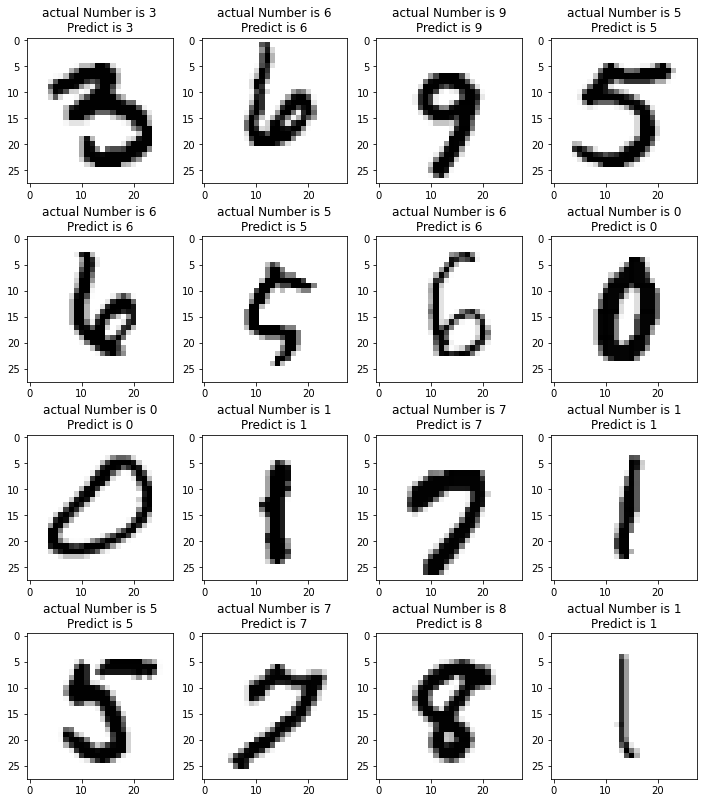

In [ ]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"actual Number is {y_test[i].argmax()}\nPredict is {y_pred[i].argmax()}");